# This Notebook uses Rotary indicTrans2 1B model for Machine Translation from English to Indian Languages. Inferenced on IN22-Gen dataset

In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
!pip install IndicTransToolkit

In [ ]:
!pip install evaluate sacrebleu

In [3]:
!nvidia-smi

Fri Aug 29 04:52:04 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P8             11W /   70W |       1MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import torch
import warnings
import json
from IndicTransToolkit.processor import IndicProcessor
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import evaluate

2025-08-30 10:35:02.002681: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756550102.270885      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756550102.346346      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# data for kas_Deva, mni_Beng,snd_Arab  not in IN22-Gen
# has an issue with inference for kas_Deva, mni_Beng
# In_langs = ['asm_Beng','ben_Beng','brx_Deva','doi_Deva','eng_Latn','gom_Deva','guj_Gujr','hin_Deva','kan_Knda','kas_Arab','kas_Deva','mai_Deva','mal_Mlym','mar_Deva','mni_Beng','mni_Mtei','npi_Deva','ory_Orya','pan_Guru','san_Deva','sat_Olck','snd_Arab','snd_Deva','tam_Taml','tel_Telu','urd_Arab']
In_langs = ['asm_Beng','ben_Beng','brx_Deva','doi_Deva','eng_Latn','gom_Deva','guj_Gujr','hin_Deva','kan_Knda','kas_Arab','mai_Deva','mal_Mlym','mar_Deva','mni_Mtei','npi_Deva','ory_Orya','pan_Guru','san_Deva','sat_Olck','snd_Arab','snd_Deva','tam_Taml','tel_Telu','urd_Arab']

In [5]:
ds  = load_dataset("ai4bharat/IN22-Gen")

README.md:   0%|          | 0.00/7.71k [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/4.34M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/1024 [00:00<?, ? examples/s]

In [6]:
ds = ds['test']

In [7]:
ds['eng_Latn'][:5]

['An appearance is a bunch of attributes related to the service person, like their shoes, clothes, tie, jewellery, hairstyle, make-up, watch, cosmetics, perfume, etc.',
 'Ajanta, located in the Aurangabad District of Maharashtra has twenty-nine caitya and vihara caves decorated with sculptures and paintings from the first century B.C.E. to the fifth century C.E.',
 'Body colour gets merged with the outer line, creating the effect of volume.',
 'Ashoka started making extensive use of stone for sculptures and great monuments, whereas the previous tradition consisted of working with wood and clay.',
 'Potatoes mixed in masalas, coated in besan batter and deep fried to perfection form this delicious and famous dish of Maharashtra.']

## Loading model for English to Indian language translation

In [9]:
warnings.filterwarnings("ignore")
model_name = "prajdabre/rotary-indictrans2-en-indic-1B"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
ip = IndicProcessor(inference=True)
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenization_indictrans.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/prajdabre/rotary-indictrans2-en-indic-1B:
- tokenization_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


dict.SRC.json: 0.00B [00:00, ?B/s]

dict.TGT.json: 0.00B [00:00, ?B/s]

model.SRC:   0%|          | 0.00/759k [00:00<?, ?B/s]

model.TGT:   0%|          | 0.00/3.26M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/96.0 [00:00<?, ?B/s]

In [11]:
model = AutoModelForSeq2SeqLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    trust_remote_code=True,
).to(device)

config.json: 0.00B [00:00, ?B/s]

configuration_rotary_indictrans.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/prajdabre/rotary-indictrans2-en-indic-1B:
- configuration_rotary_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_rotary_indictrans.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/prajdabre/rotary-indictrans2-en-indic-1B:
- modeling_rotary_indictrans.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/4.46G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/4.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

In [12]:
translations = {}

In [13]:
batch_size = 10

In [14]:
def translate(sentences,src_lang, tgt_lang):
    translations[f"{src_lang}-{tgt_lang}"] = []
    with torch.inference_mode():
        for i in range(0, len(sentences),batch_size):
            batch = ip.preprocess_batch(sentences[i:i+batch_size], src_lang, tgt_lang)
            batch = tokenizer(batch, padding="longest", truncation=True, max_length=2048, return_tensors="pt").to(device)
            outputs = model.generate(
                **batch,
                num_beams=8,
                length_penalty=1.5,
                repetition_penalty=2.0,
                num_return_sequences=1,
                max_new_tokens=2048,
                early_stopping=True
            )

            outputs = tokenizer.batch_decode(
                outputs, skip_special_tokens=True, clean_up_tokenization_spaces=True
            )
            outputs = ip.postprocess_batch(outputs, lang = tgt_lang)
            print(f"Translations from {src_lang} to {tgt_lang}: Btach - {i/batch_size}")
            translations[f"{src_lang}-{tgt_lang}"] += outputs
            del batch, outputs
            torch.cuda.empty_cache()

## Inferencing and Saving the output to a json file

In [ ]:
src_Lang = 'eng_Latn'
for lang in In_langs:
    translate(sentences = ds[src_Lang],src_lang = src_Lang, tgt_lang = lang)
    try:
        with open("translations_en-in.json", "w", encoding="utf-8") as f:
            json.dump(translations, f, indent=4, ensure_ascii=False)
        print(f"File saved as of {lang}")
    except IOError as e:
        print(f"Error saving file: {e}")
            

In [16]:
translations.keys()

dict_keys(['eng_Latn-asm_Beng'])

## Loading the saved translations

In [8]:
with open('/kaggle/input/translations-en-in/translations_en-in.json','r',encoding='utf-8') as f:
    translations = json.load(f)

In [10]:
translations.keys()

dict_keys(['eng_Latn-asm_Beng', 'eng_Latn-ben_Beng', 'eng_Latn-brx_Deva', 'eng_Latn-doi_Deva', 'eng_Latn-eng_Latn', 'eng_Latn-gom_Deva', 'eng_Latn-guj_Gujr', 'eng_Latn-hin_Deva', 'eng_Latn-kan_Knda', 'eng_Latn-kas_Arab', 'eng_Latn-mai_Deva', 'eng_Latn-mal_Mlym', 'eng_Latn-mar_Deva', 'eng_Latn-mni_Mtei', 'eng_Latn-npi_Deva', 'eng_Latn-ory_Orya', 'eng_Latn-pan_Guru', 'eng_Latn-san_Deva', 'eng_Latn-sat_Olck', 'eng_Latn-snd_Arab', 'eng_Latn-snd_Deva', 'eng_Latn-tam_Taml', 'eng_Latn-tel_Telu', 'eng_Latn-urd_Arab'])

In [13]:
print(translations['eng_Latn-tam_Taml'][0])
ds['tam_Taml'][0]

தோற்றம் என்பது சேவை செய்பவரின் காலணிகள், உடைகள், டை, நகைகள், சிகை அலங்காரம், ஒப்பனை, கடிகாரம், அழகுசாதனப் பொருட்கள், வாசனை திரவியங்கள் போன்றவற்றுடன் தொடர்புடைய பண்புகளின் தொகுப்பாகும்.


'தோற்றம் என்பது சேவை ஊழியரின் காலணிகள், உடை, டை, நகை, சிகையலங்காரம், மேக்-அப், கைக்கடிகாரம், அழகு சாதனங்கள், நறுமணம் போன்ற அவர் சார்ந்த பண்புகளின் ஒரு தொகுப்பைக் குறிக்கிறது.'

## Evaluating the Translations

In [21]:
avl_langs = ['asm_Beng','ben_Beng','brx_Deva','doi_Deva','eng_Latn','gom_Deva','guj_Gujr','hin_Deva','kan_Knda','kas_Arab','mai_Deva','mal_Mlym','mar_Deva','mni_Mtei','npi_Deva','ory_Orya','pan_Guru','san_Deva','sat_Olck','snd_Deva','tam_Taml','tel_Telu','urd_Arab']

In [22]:
evaluation_scores = {}

In [23]:
chrf = evaluate.load("chrf")

In [24]:
def reshape_to_2D(refs):
    return np.array(refs).reshape(-1,1)

In [25]:
for lang in avl_langs:
    preds = translations[f"eng_Latn-{lang}"]
    refs = ds[lang]
    eval_score = chrf.compute(predictions = preds, references = reshape_to_2D(refs), word_order = 2)
    evaluation_scores[lang] = []
    evaluation_scores[lang] = eval_score['score']

In [26]:
evaluation_scores

{'asm_Beng': 44.95942691046476,
 'ben_Beng': 47.28212708193074,
 'brx_Deva': 39.58070861461832,
 'doi_Deva': 58.225645673027685,
 'eng_Latn': 2.3775945713611253,
 'gom_Deva': 42.327405936889164,
 'guj_Gujr': 52.27170841790074,
 'hin_Deva': 54.999156894285036,
 'kan_Knda': 48.48043471062446,
 'kas_Arab': 32.06844576306507,
 'mai_Deva': 48.09914515235024,
 'mal_Mlym': 46.77744121678397,
 'mar_Deva': 49.59458161733089,
 'mni_Mtei': 44.659737413441576,
 'npi_Deva': 47.053012507106004,
 'ory_Orya': 41.40366796015004,
 'pan_Guru': 48.35199493009035,
 'san_Deva': 36.459416637993904,
 'sat_Olck': 40.59647294743415,
 'snd_Deva': 39.56466548668205,
 'tam_Taml': 49.849307954427836,
 'tel_Telu': 51.71540907423323,
 'urd_Arab': 66.35757738856296}

## Visualizing the outputs

In [27]:
score = [val for val in evaluation_scores.values()]
score = reshape_to_2D(score)
score

array([[44.95942691],
       [47.28212708],
       [39.58070861],
       [58.22564567],
       [ 2.37759457],
       [42.32740594],
       [52.27170842],
       [54.99915689],
       [48.48043471],
       [32.06844576],
       [48.09914515],
       [46.77744122],
       [49.59458162],
       [44.65973741],
       [47.05301251],
       [41.40366796],
       [48.35199493],
       [36.45941664],
       [40.59647295],
       [39.56466549],
       [49.84930795],
       [51.71540907],
       [66.35757739]])

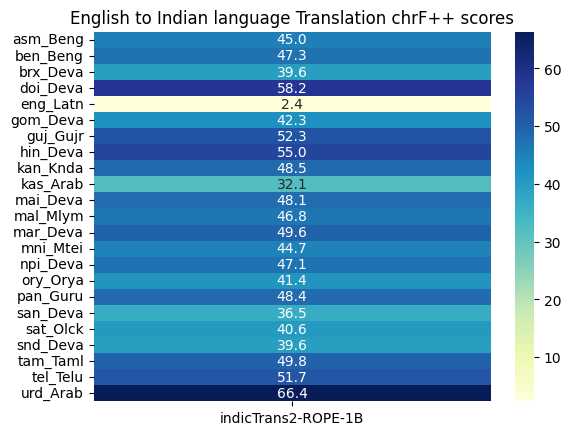

In [28]:
sns.heatmap(score,annot=True, fmt=".1f",xticklabels = ["indicTrans2-ROPE-1B"],yticklabels = evaluation_scores.keys(),cmap = 'YlGnBu')
plt.title("English to Indian language Translation chrF++ scores")
plt.show()